In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Input, Bidirectional,Embedding
from keras.layers import Dense, Activation, Dropout

from tensorflow import keras
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt' , 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [3]:
text = open(path_to_file , 'rb').read().decode( encoding='utf-8' )

print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [5]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [6]:
ids_from_chars = preprocessing.StringLookup(vocabulary = list(vocab),
                                            mask_token=None)

In [7]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None
)

In [8]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [9]:
all_ids = ids_from_chars(tf.strings.unicode_split(text , 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [10]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [11]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [12]:
seq_length = 50
examples_per_epoch = len(text)//(seq_length+1)

In [13]:
sequences = ids_dataset.batch(seq_length+1 , drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' '], shape=(51,), dtype=string)


In [14]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text , target_text

In [15]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example , target_example in dataset.take(1):
  print('Input: ',text_from_ids(input_example).numpy())
  print('Target: ',text_from_ids(target_example).numpy())

In [17]:
batch_size = 64

buffer_size = 10000

dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size,drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [18]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024

In [19]:
def loss_plot(history):
  plt.xlabel("Number of Epochs")
  plt.ylabel('Loss', fontsize=16)
  plt.plot(history.history['loss'], color='b', label='Training Loss')
  plt.legend(loc='upper right')
  plt.show()

# LSTM

In [27]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer=tf.keras.initializers.GlorotNormal()
                                   )
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, mem_states, carry_state = self.lstm(x, initial_state=states, training=training)
    states = [mem_states, carry_state]
    x = self.dense(x, training=training)

    if return_state:
      return x,states
    else:
      return x

In [28]:
lstm_model_2 = MyModel(
    vocab_size = len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

In [29]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [30]:
opt = keras.optimizers.RMSprop(learning_rate=1e-3)
lstm_model_2.compile(optimizer=opt, loss=loss)

In [31]:
checkpoint_dir = './training_checkpoints_LSTM2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [34]:
epochs = 200

In [35]:
early_stopping = EarlyStopping(monitor = 'loss',min_delta=0.001, patience = 10, mode = 'min', verbose = 2)
reduce_lr =  ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0000001, verbose=2)
history_lstm = lstm_model_2.fit(dataset, epochs=epochs, callbacks=[early_stopping, reduce_lr, checkpoint_callback])

Epoch 1/200
341/341 [==============================] - 30s 85ms/step - loss: 2.1743
Epoch 2/200
341/341 [==============================] - 30s 85ms/step - loss: 1.6165
Epoch 3/200
341/341 [==============================] - 30s 86ms/step - loss: 1.4473
Epoch 4/200
341/341 [==============================] - 30s 86ms/step - loss: 1.3603
Epoch 5/200
341/341 [==============================] - 30s 86ms/step - loss: 1.2977
Epoch 6/200
341/341 [==============================] - 30s 86ms/step - loss: 1.2426
Epoch 7/200
341/341 [==============================] - 30s 85ms/step - loss: 1.1885
Epoch 8/200
341/341 [==============================] - 30s 86ms/step - loss: 1.1337
Epoch 9/200
341/341 [==============================] - 30s 86ms/step - loss: 1.0760
Epoch 10/200
341/341 [==============================] - 30s 86ms/step - loss: 1.0157
Epoch 11/200
341/341 [==============================] - 30s 86ms/step - loss: 0.9533
Epoch 12/200
341/341 [==============================] - 30s 86ms/step - lo

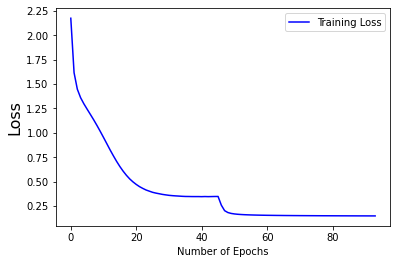

In [36]:
loss_plot(history_lstm)

In [37]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(

        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):

    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [38]:
one_step_model = OneStep(lstm_model_2, chars_from_ids, ids_from_chars)

In [39]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
I have night's cloak to hide me from their speech,
And never brand by the nose which Longon
Wis cold to sort a good white:
I will not budghen out of parison, and your solemn torserves
Which five hash that purposed my heart to thee and badest than till
The run but worth of death.

SEBASTIAN:
With all my heart as you shall find
me yare; for truly, sir, for your brother's death.

BALTARAT:
Thank, for this good Coriolanus 'head him a tombor's friend
And then take order them with all crown'd
worthy with a gentlemanly shamen to him.

Shepherd:
And so have I, by the wager be't in my a time was ever peace
To sinner Vincentio.

First Citizen:
Let us kill my brother; we will unto the occident,
Which, without contrived in soothing men, you know
Our sorrow'd life in house of his mellow
And heap it all answering beauty served and fresh.

GREGORY:
The hate physicing souls have heard him stay.
Trive me there, my gracious lord, expecially affeir.

ANGELO:
Good night.
This deed unbound to this e

In [40]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nAlas, that 'outish'd, my companion is the stroke\nBetween the life that trembled upon this world,\nAs scarish'd, my soul is not hath knock'd and swore.\n\nBRUTUS:\nNot possible.\n\nCORIOLANUS:\nWhat is this?\nYour purse is not Rome back to your young prince.\n\nKING EDWARD IV:\nWell, jest on, bring me to her her.\n\nLADY CAPULET:\nFie, freely I wish you not.\n\nJULIET:\nThe king did for a thing when thou art experity.\nBut what talk I of Antigonus,' and Master\ncoust, as I can devise, I am a book for Rome, and one than to live\nTo murder me and to my ward through our levies, now in again thy face,\nThat gives not himself on Tarpeige betwixt you thanks.\n\nKING EDWARD IV:\nBishop or what thou hast marr'd, this world but zell in earth.\n\nBAPTISTA:\nWho comes with your honour with him! he will return before\nHis tears do plot them and then lay in my days would behold\nThe stern you find on herself.\n\nGLOUCESTER:\nMy lord, some have I scold to strike all this goodly

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [42]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
I have night's cloak to hide me from their sprites;
But for the world were hand no less than ever:

